In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Load data
df_path_abun = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/pathways_out/path_abun_contrib.tsv', sep='\t', dtype=str, header=0, usecols=['sample', 'function', 'taxon', 'taxon_abun', 'taxon_function_abun'])
df_tax = pd.read_csv('~/Thesis/data/tax_complete_qiime.txt', sep='\t', dtype=str, header=None, names=['taxon', 'taxonomy'])
df_meta = pd.read_csv('~/Thesis/data/metadata.txt', sep='\t', dtype=str, header=0, usecols=['Barcode ', 'ReactorID'])
df_nsti = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/KO_metagenome_out/weighted_nsti.tsv', sep='\t', dtype=str, header=0)

# Remove invisible spacings
df_path_abun['sample'] = df_path_abun['sample'].str.strip()

In [13]:
### Save files
df_path_abun.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_path_abun.tsv', sep='\t', index=False)
df_tax.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_tax.tsv', sep='\t', index=False)
df_meta.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_meta.tsv', sep='\t', index=False)
df_nsti.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_nsti.tsv', sep='\t', index=False)

In [3]:
# Filter for PR1 and PR4
barcodes = df_meta[df_meta['ReactorID'].isin(['PR1', 'PR4'])]['Barcode '].tolist()
df_path_abun = df_path_abun[df_path_abun['sample'].isin(barcodes)].copy()
PR1 = df_meta[df_meta['ReactorID'].isin(['PR1'])]['Barcode '].tolist()
PR4 = df_meta[df_meta['ReactorID'].isin(['PR4'])]['Barcode '].tolist()

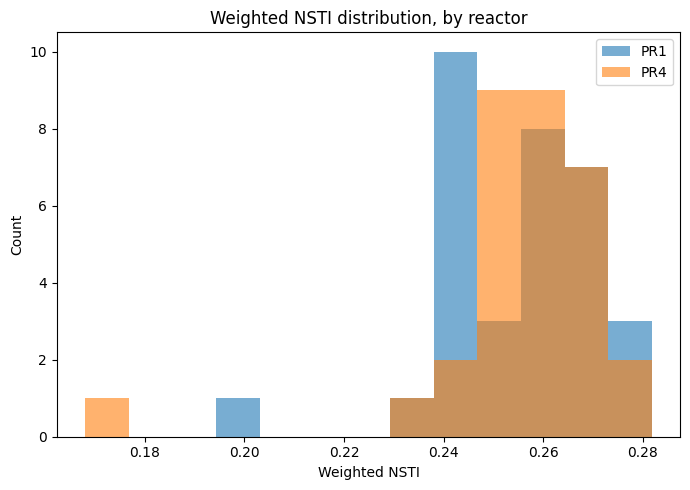

In [4]:
### Weighted NSTI distribution

# Numeric values
df_nsti['weighted_NSTI'] = pd.to_numeric(df_nsti['weighted_NSTI'], errors='coerce').copy()


# Generate boolean masks for PR1 and PR4
mask_pr1 = df_nsti['sample'].isin(PR1)
mask_pr4 = df_nsti['sample'].isin(PR4)

# Common bins for both groups
all_vals = df_nsti.loc[mask_pr1 | mask_pr4, 'weighted_NSTI'].dropna().values
bins = np.histogram_bin_edges(all_vals, bins='auto') if len(all_vals) else 20

# Histogram of weighted NSTI values
plt.figure(figsize=(7, 5))
plt.hist(df_nsti.loc[mask_pr1, 'weighted_NSTI'].dropna(), bins=bins, alpha=0.6, label='PR1', density=False)
plt.hist(df_nsti.loc[mask_pr4, 'weighted_NSTI'].dropna(), bins=bins, alpha=0.6, label='PR4', density=False)
plt.xlabel('Weighted NSTI')
plt.ylabel('Count')
plt.title('Weighted NSTI distribution, by reactor')
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
### Compute genus-level pathway abundances

# Pathways of interest
pathways = ['METH-ACETATE-PWY', # Acetoclastic methanogenesis
            'METHANOGENESIS-PWY'] # Hydrogenotrophic methanogenesis


# Keep what's needed
df = df_path_abun[['sample', 'function', 'taxon', 'taxon_function_abun']].copy()


# Ensure numeric abundance
df['taxon_function_abun'] = pd.to_numeric(df['taxon_function_abun'], errors='coerce').fillna(0.0)


# Fix whitespacing
df_tax["taxon"] = df_tax["taxon"].str.strip()
df_tax["taxonomy"] = df_tax["taxonomy"].str.strip()


# Merge taxonomy onto pathway abundance data
df = df.merge(df_tax, on='taxon', how='left').copy()


# Split taxonomies up into seperate columns
ranks = {
    "kingdom": "k__", "phylum": "p__", "class": "c__", "order": "o__",
    "family": "f__", "genus": "g__", "species": "s__"
}


# Extract each rank from the semicolon-delimited string
for col, prefix in ranks.items():
    df[col] = df["taxonomy"].str.extract(fr"{prefix}\s*([^;]+)", expand=False).str.strip()


# Collapse ASV level pathway abundance to genus-level pathway abundance
PR1_abun_genus = (
    df[df["sample"].isin(PR1)]
      .groupby(["function", "genus"], as_index=False)["taxon_function_abun"]
      .sum()
      .rename(columns={"taxon_function_abun": "total_contribution"})
)
PR4_abun_genus = (
    df[df["sample"].isin(PR4)]
      .groupby(["function", "genus"], as_index=False)["taxon_function_abun"]
      .sum()
      .rename(columns={"taxon_function_abun": "total_contribution"})
)



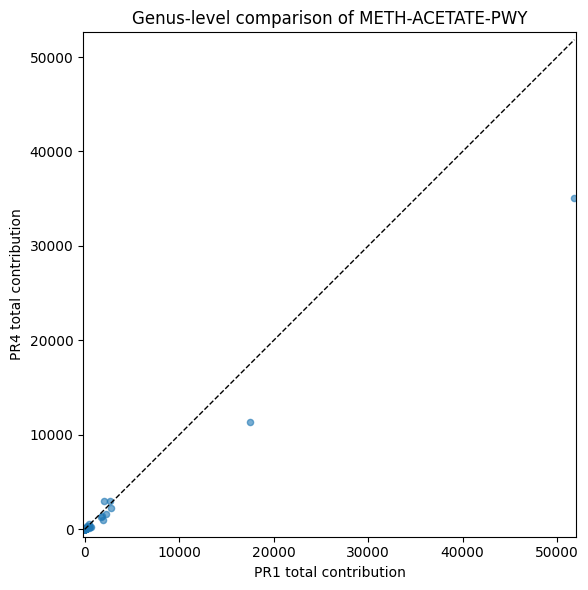

In [20]:
### Histogram


# Genus level pathway abundance for acetoclastic methanogenesis
PR1_sub = PR1_abun_genus[PR1_abun_genus['function'] == 'METH-ACETATE-PWY'].copy()
PR4_sub = PR4_abun_genus[PR4_abun_genus['function'] == 'METH-ACETATE-PWY'].copy()




# Ensure the two columns exist and are numeric
merged = PR1_sub.merge(PR4_sub, on='genus', how='outer',
                       suffixes=('_PR1','_PR4')).fillna(0)
for c in ['total_contribution_PR1','total_contribution_PR4']:
    merged[c] = pd.to_numeric(merged[c], errors='coerce').fillna(0)

# Scatter
import numpy as np
import matplotlib.pyplot as plt

x = merged['total_contribution_PR1'].to_numpy()
y = merged['total_contribution_PR4'].to_numpy()

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.6, s=20)
m = np.nanmax(np.concatenate([x, y]))  # numeric max only
plt.plot([0, m], [0, m], 'k--', linewidth=1)  # 1:1 diagonal
plt.xlabel('PR1 total contribution')
plt.ylabel('PR4 total contribution')
plt.title('Genus-level comparison of METH-ACETATE-PWY')
plt.axis('equal'); plt.xlim(0, m); plt.ylim(0, m)
plt.tight_layout(); plt.show()


In [17]:
print(PR4_abun_genus.head(100))


print(PR1_abun_genus[PR1_abun_genus["function"] == "METH-ACETATE-PWY"]
      .nlargest(15, "total_contribution")[["genus", "total_contribution"]])




      function            genus  total_contribution
0   1CMET2-PWY             28-4           18.000000
1   1CMET2-PWY   ADurb.Bin063-1            2.153846
2   1CMET2-PWY  Abditibacterium            1.000000
3   1CMET2-PWY   Acetitomaculum            6.461538
4   1CMET2-PWY      Acetivibrio          192.500000
..         ...              ...                 ...
95  1CMET2-PWY          Daeguia           14.000000
96  1CMET2-PWY   Defluviicoccus            1.000000
97  1CMET2-PWY    Defluviitalea         9693.000000
98  1CMET2-PWY     Defluviitoga        59526.060000
99  1CMET2-PWY     Dehalobacter            0.282258

[100 rows x 3 columns]
                  genus  total_contribution
29479  Syntrophaceticus        51828.571429
29502      midas_g_1240        17446.066667
29514      midas_g_4921         2749.714286
29524     midas_g_90696         2685.714286
29478        Romboutsia         2235.357143
29530     midas_g_92005         2027.428571
29474          Moorella         1882.666667


In [18]:
print(PR4_abun_genus[PR4_abun_genus["function"] == "METH-ACETATE-PWY"]
      .nlargest(15, "total_contribution")[["genus", "total_contribution"]])

                  genus  total_contribution
25489  Syntrophaceticus        35078.857143
25506      midas_g_1240        11346.586667
25532     midas_g_92005         2966.857143
25527     midas_g_90696         2961.142857
25517      midas_g_4921         2294.857143
25488        Romboutsia         1664.342857
25486  Paeniclostridium         1371.428571
25493  Terrisporobacter         1271.894118
25485          Moorella          997.333333
25537     midas_g_93820          541.500000
25515      midas_g_3406          345.000000
25479   Desulfitibacter          294.500000
25546     midas_g_99090          293.714286
25536     midas_g_93804          259.000000
25531       midas_g_917          210.640000
